# Walmart Sales Forecasting: Data Exploration & Hydra Training

This notebook provides comprehensive data exploration, statistical analysis, and model training for Walmart retail sales forecasting using Hydra configuration management.

## Table of Contents
1. [Data Loading & Overview](#data-loading)
2. [Exploratory Data Analysis](#eda)
3. [Statistical Analysis](#stats)
4. [Custom Dataset Exploration](#custom-dataset)
5. [Model Training with Hydra](#hydra-training)
6. [Model Comparison](#comparison)
7. [Conclusions](#conclusions)

## Setup and Imports

Import all necessary libraries for data analysis and visualization.

In [2]:
# Core data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Statistical analysis
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

# Plotting configuration
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Custom dataset and Hydra - Fix path setup
import sys
import os
from pathlib import Path

# Add both the project root and the src directory to Python path
current_dir = Path(os.getcwd())
project_root = current_dir.parent  # Go up from notebooks to project root
repo_root = project_root.parent.parent  # Go up to repository root
src_path = repo_root / "src"

# Add paths
sys.path.insert(0, str(project_root))  # For local data module
sys.path.insert(0, str(src_path))      # For ml_portfolio shared library

print(f"Current directory: {current_dir}")
print(f"Project root: {project_root}")
print(f"Repository root: {repo_root}")
print(f"Source path: {src_path}")

# Now import the custom datasets
try:
    from data.walmart_dataset import WalmartTimeSeriesDataset, WalmartMultiStoreDataset
    print("Custom datasets imported successfully!")
except ImportError as e:
    print(f"Import error: {e}")
    print("Will continue without custom datasets")
    WalmartTimeSeriesDataset = None
    WalmartMultiStoreDataset = None

print("Libraries imported successfully!")
print(f"Working directory: {os.getcwd()}")

Current directory: c:\Users\mvill\github\forecasting_demo\projects\retail_sales_walmart\notebooks
Project root: c:\Users\mvill\github\forecasting_demo\projects\retail_sales_walmart
Repository root: c:\Users\mvill\github\forecasting_demo
Source path: c:\Users\mvill\github\forecasting_demo\src
Custom datasets imported successfully!
Libraries imported successfully!
Working directory: c:\Users\mvill\github\forecasting_demo\projects\retail_sales_walmart\notebooks


<a id="data-loading"></a>
## 1. Data Loading & Overview

Load the raw Walmart dataset and examine its structure.

In [4]:
# Load raw Walmart data
data_path = '../data/raw/Walmart.csv'

df = pd.read_csv(data_path)
print(f"Data loaded successfully from {data_path}")
print(f"Dataset shape: {df.shape}")

# Display basic information
print("\nDataset Info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())


Data loaded successfully from ../data/raw/Walmart.csv
Dataset shape: (6435, 8)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB
None

First few rows:
   Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0     

In [10]:
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'] ,format='%d-%m-%Y')

# Basic statistics
print("Dataset Summary Statistics:")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Number of stores: {df['Store'].nunique()}")
print(f"Number of weeks: {df['Date'].nunique()}")
print(f"Total observations: {len(df)}")

print("\nNumerical columns summary:")
df.describe()

Dataset Summary Statistics:
Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
Number of stores: 45
Number of weeks: 143
Total observations: 6435

Numerical columns summary:


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6435,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,2011-06-17 00:00:00,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
min,1.000000,2010-02-05 00:00:00,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,2010-10-08 00:00:00,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,2011-06-17 00:00:00,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,2012-02-24 00:00:00,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,2012-10-26 00:00:00,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000
std,12.988182,NaN,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885


<a id="eda"></a>
## 2. Exploratory Data Analysis

Visualize the data to understand patterns, trends, and seasonality.

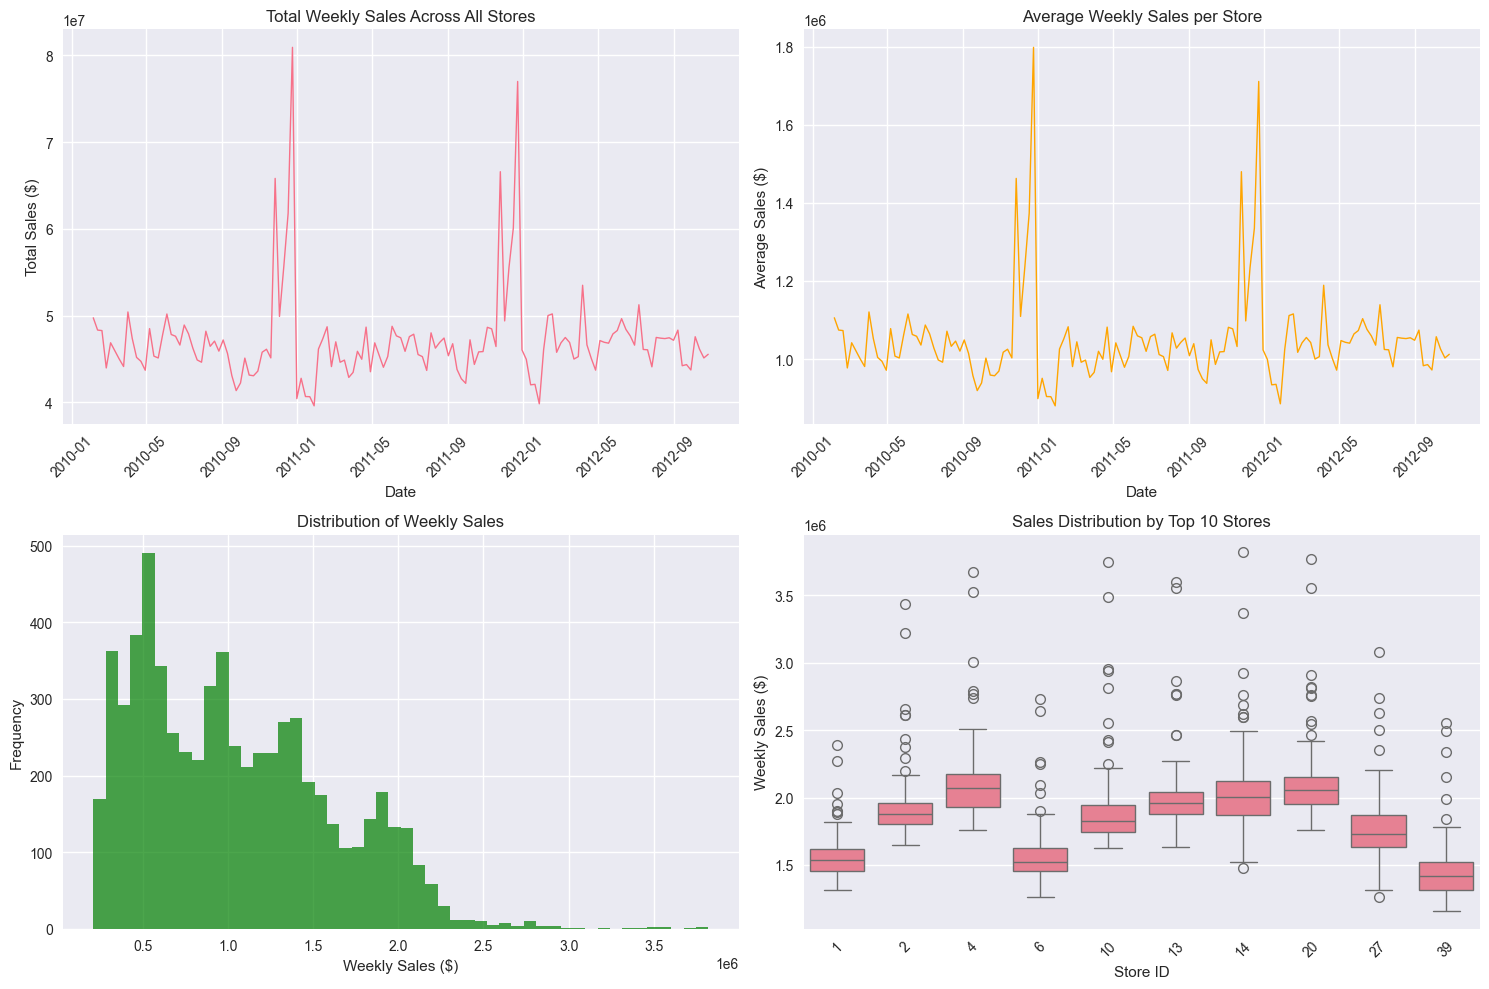

Total sales across all stores and time: $6,737,218,987
Average weekly sales per store: $1,046,965


In [11]:
# Aggregate data by date for overall trend analysis
daily_sales = df.groupby('Date')['Weekly_Sales'].agg(['sum', 'mean', 'std']).reset_index()
daily_sales.columns = ['Date', 'Total_Sales', 'Avg_Sales', 'Std_Sales']

# Time series plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Total sales over time
axes[0,0].plot(daily_sales['Date'], daily_sales['Total_Sales'], linewidth=1)
axes[0,0].set_title('Total Weekly Sales Across All Stores')
axes[0,0].set_xlabel('Date')
axes[0,0].set_ylabel('Total Sales ($)')
axes[0,0].tick_params(axis='x', rotation=45)

# Average sales over time
axes[0,1].plot(daily_sales['Date'], daily_sales['Avg_Sales'], linewidth=1, color='orange')
axes[0,1].set_title('Average Weekly Sales per Store')
axes[0,1].set_xlabel('Date')
axes[0,1].set_ylabel('Average Sales ($)')
axes[0,1].tick_params(axis='x', rotation=45)

# Sales distribution
axes[1,0].hist(df['Weekly_Sales'], bins=50, alpha=0.7, color='green')
axes[1,0].set_title('Distribution of Weekly Sales')
axes[1,0].set_xlabel('Weekly Sales ($)')
axes[1,0].set_ylabel('Frequency')

# Box plot by store (top 10 stores)
top_stores = df.groupby('Store')['Weekly_Sales'].mean().nlargest(10).index
store_data = df[df['Store'].isin(top_stores)]
sns.boxplot(data=store_data, x='Store', y='Weekly_Sales', ax=axes[1,1])
axes[1,1].set_title('Sales Distribution by Top 10 Stores')
axes[1,1].set_xlabel('Store ID')
axes[1,1].set_ylabel('Weekly Sales ($)')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"Total sales across all stores and time: ${daily_sales['Total_Sales'].sum():,.0f}")
print(f"Average weekly sales per store: ${daily_sales['Avg_Sales'].mean():,.0f}")

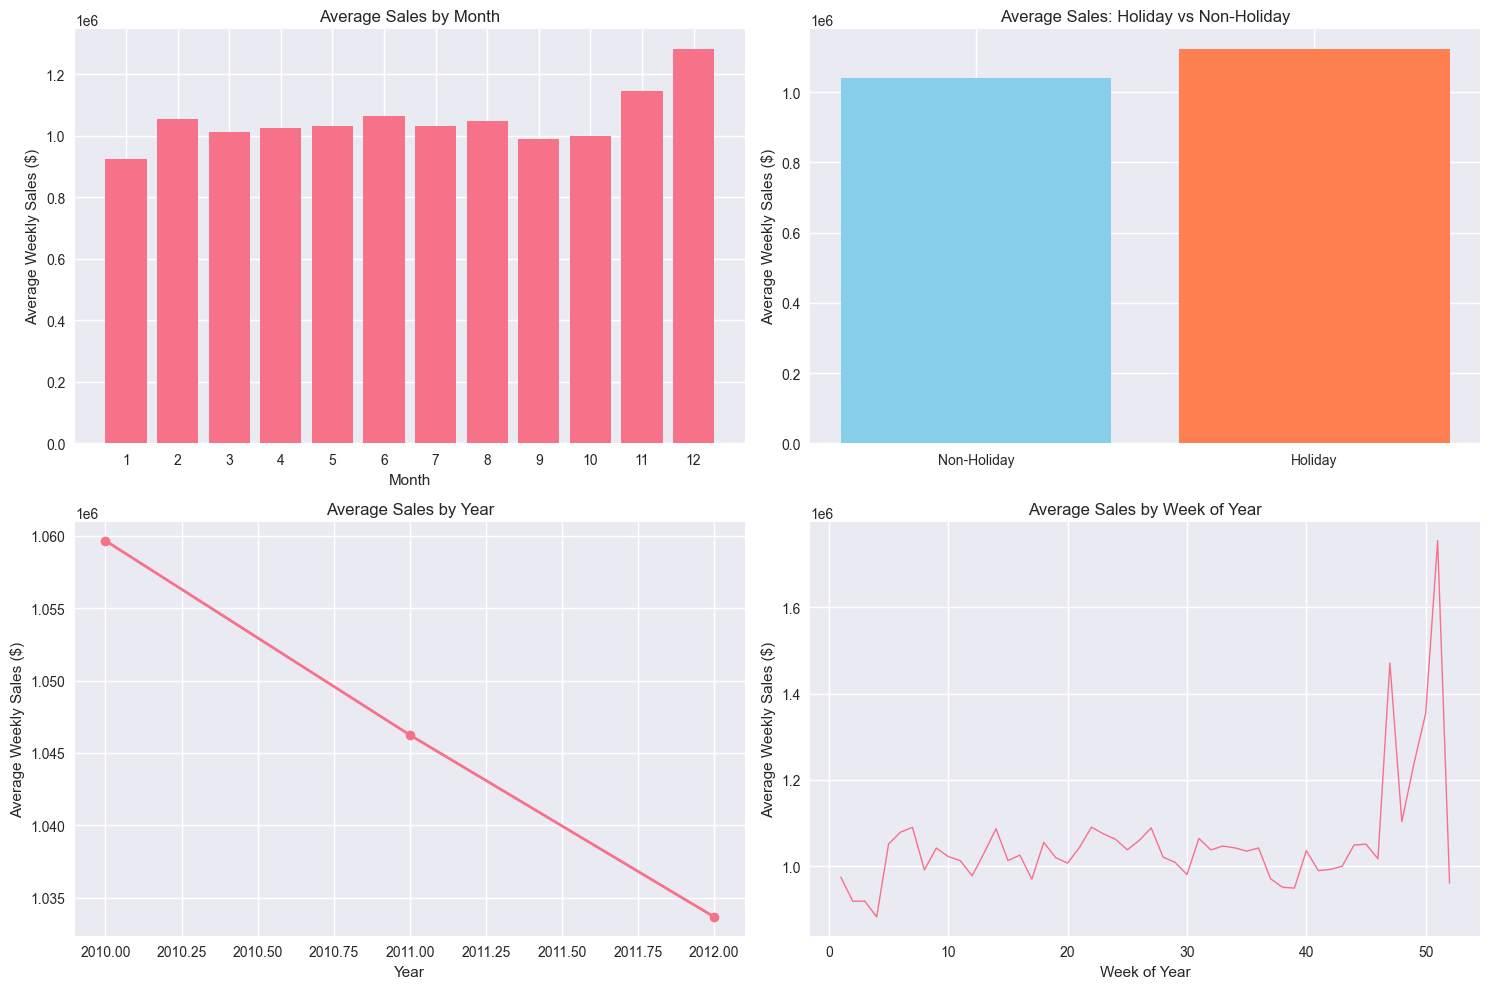

Seasonal Insights:
Highest sales month: 12 ($1,281,864)
Lowest sales month: 1 ($923,885)
Holiday sales boost: 7.8%


In [12]:
# Seasonal and holiday analysis
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Week_of_Year'] = df['Date'].dt.isocalendar().week

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Monthly sales pattern
monthly_sales = df.groupby('Month')['Weekly_Sales'].mean()
axes[0,0].bar(monthly_sales.index, monthly_sales.values)
axes[0,0].set_title('Average Sales by Month')
axes[0,0].set_xlabel('Month')
axes[0,0].set_ylabel('Average Weekly Sales ($)')
axes[0,0].set_xticks(range(1, 13))

# Holiday vs non-holiday sales
holiday_sales = df.groupby('Holiday_Flag')['Weekly_Sales'].mean()
axes[0,1].bar(['Non-Holiday', 'Holiday'], holiday_sales.values, color=['skyblue', 'coral'])
axes[0,1].set_title('Average Sales: Holiday vs Non-Holiday')
axes[0,1].set_ylabel('Average Weekly Sales ($)')

# Yearly trend
yearly_sales = df.groupby('Year')['Weekly_Sales'].mean()
axes[1,0].plot(yearly_sales.index, yearly_sales.values, marker='o', linewidth=2)
axes[1,0].set_title('Average Sales by Year')
axes[1,0].set_xlabel('Year')
axes[1,0].set_ylabel('Average Weekly Sales ($)')

# Week of year pattern
weekly_pattern = df.groupby('Week_of_Year')['Weekly_Sales'].mean()
axes[1,1].plot(weekly_pattern.index, weekly_pattern.values, linewidth=1)
axes[1,1].set_title('Average Sales by Week of Year')
axes[1,1].set_xlabel('Week of Year')
axes[1,1].set_ylabel('Average Weekly Sales ($)')

plt.tight_layout()
plt.show()

print("Seasonal Insights:")
print(f"Highest sales month: {monthly_sales.idxmax()} (${monthly_sales.max():,.0f})")
print(f"Lowest sales month: {monthly_sales.idxmin()} (${monthly_sales.min():,.0f})")
print(f"Holiday sales boost: {((holiday_sales[1] - holiday_sales[0]) / holiday_sales[0] * 100):.1f}%")

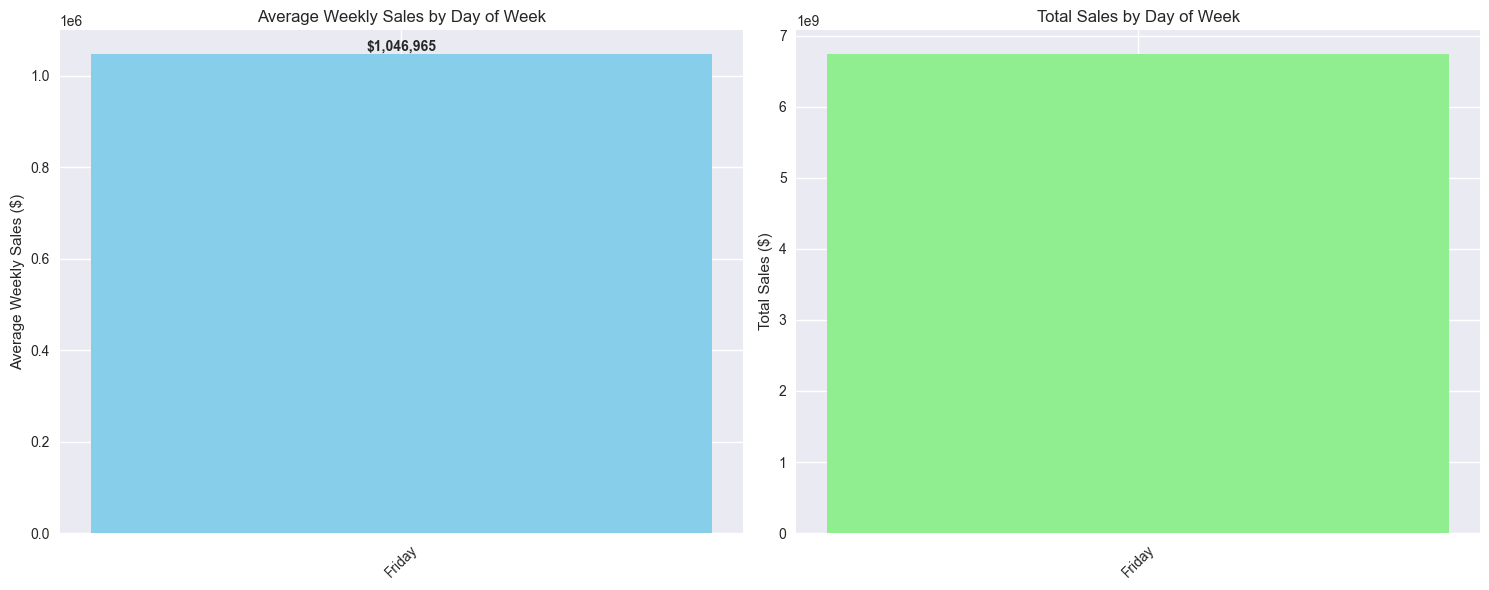

DAILY SALES PATTERNS:
Highest sales day: Friday ($1,046,965 average)
Lowest sales day: Friday ($1,046,965 average)
Sales difference: $0 (0.0% higher)

All days ranked by average sales:
🥇 Friday    | $1,046,965


In [14]:
# Day of week analysis - which days have higher sales patterns
df['Day_of_Week'] = df['Date'].dt.day_name()
df['Weekday_Num'] = df['Date'].dt.dayofweek  # Monday=0, Sunday=6

# Calculate average sales by day of week
daily_pattern = df.groupby(['Day_of_Week', 'Weekday_Num'])['Weekly_Sales'].agg(['mean', 'sum', 'count']).reset_index()

# Flatten the column names to avoid multi-level indexing issues
daily_pattern.columns = ['Day_of_Week', 'Weekday_Num', 'Avg_Sales', 'Total_Sales', 'Count']
daily_pattern = daily_pattern.sort_values('Weekday_Num')  # Sort Monday to Sunday

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Average sales by day of week
axes[0].bar(daily_pattern['Day_of_Week'], daily_pattern['Avg_Sales'], 
           color=['red' if day == 'Monday' else 'skyblue' for day in daily_pattern['Day_of_Week']])
axes[0].set_title('Average Weekly Sales by Day of Week')
axes[0].set_ylabel('Average Weekly Sales ($)')
axes[0].tick_params(axis='x', rotation=45)

# Add value labels on bars
for i, (day, value) in enumerate(zip(daily_pattern['Day_of_Week'], daily_pattern['Avg_Sales'])):
    axes[0].text(i, value + 1000, f'${value:,.0f}', ha='center', va='bottom', fontweight='bold')

# Total sales by day of week
axes[1].bar(daily_pattern['Day_of_Week'], daily_pattern['Total_Sales'], 
           color=['red' if day == 'Monday' else 'lightgreen' for day in daily_pattern['Day_of_Week']])
axes[1].set_title('Total Sales by Day of Week')
axes[1].set_ylabel('Total Sales ($)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Find the day with highest and lowest sales
highest_day = daily_pattern.loc[daily_pattern['Avg_Sales'].idxmax(), 'Day_of_Week']
lowest_day = daily_pattern.loc[daily_pattern['Avg_Sales'].idxmin(), 'Day_of_Week']
highest_avg = daily_pattern['Avg_Sales'].max()
lowest_avg = daily_pattern['Avg_Sales'].min()

print("DAILY SALES PATTERNS:")
print("=" * 30)
print(f"Highest sales day: {highest_day} (${highest_avg:,.0f} average)")
print(f"Lowest sales day: {lowest_day} (${lowest_avg:,.0f} average)")
print(f"Sales difference: ${highest_avg - lowest_avg:,.0f} ({((highest_avg - lowest_avg) / lowest_avg * 100):.1f}% higher)")

print("\nAll days ranked by average sales:")
for _, row in daily_pattern.sort_values('Avg_Sales', ascending=False).iterrows():
    day = row['Day_of_Week']
    avg_sales = row['Avg_Sales']
    emoji = "🥇" if day == highest_day else "🥈" if avg_sales == daily_pattern['Avg_Sales'].nlargest(2).iloc[1] else "🥉" if avg_sales == daily_pattern['Avg_Sales'].nlargest(3).iloc[2] else "📊"
    print(f"{emoji} {day:9} | ${avg_sales:,.0f}")

<a id="stats"></a>
## 3. Statistical Analysis

Perform time series statistical analysis including stationarity tests and correlation analysis.

In [15]:
# Prepare aggregated time series for analysis
ts_data = daily_sales.set_index('Date')['Total_Sales'].sort_index()

# Stationarity test
def check_stationarity(timeseries, title):
    print(f'\n=== {title} ===')
    
    # Augmented Dickey-Fuller test
    result = adfuller(timeseries.dropna())
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print("Result: Series is stationary (reject null hypothesis)")
    else:
        print("Result: Series is non-stationary (fail to reject null hypothesis)")
    
    return result[1] <= 0.05

# Test original series
is_stationary = check_stationarity(ts_data, "Original Time Series")

# Test first difference if not stationary
if not is_stationary:
    ts_diff = ts_data.diff().dropna()
    check_stationarity(ts_diff, "First Differenced Series")


=== Original Time Series ===
ADF Statistic: -5.908298
p-value: 0.000000
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578
Result: Series is stationary (reject null hypothesis)


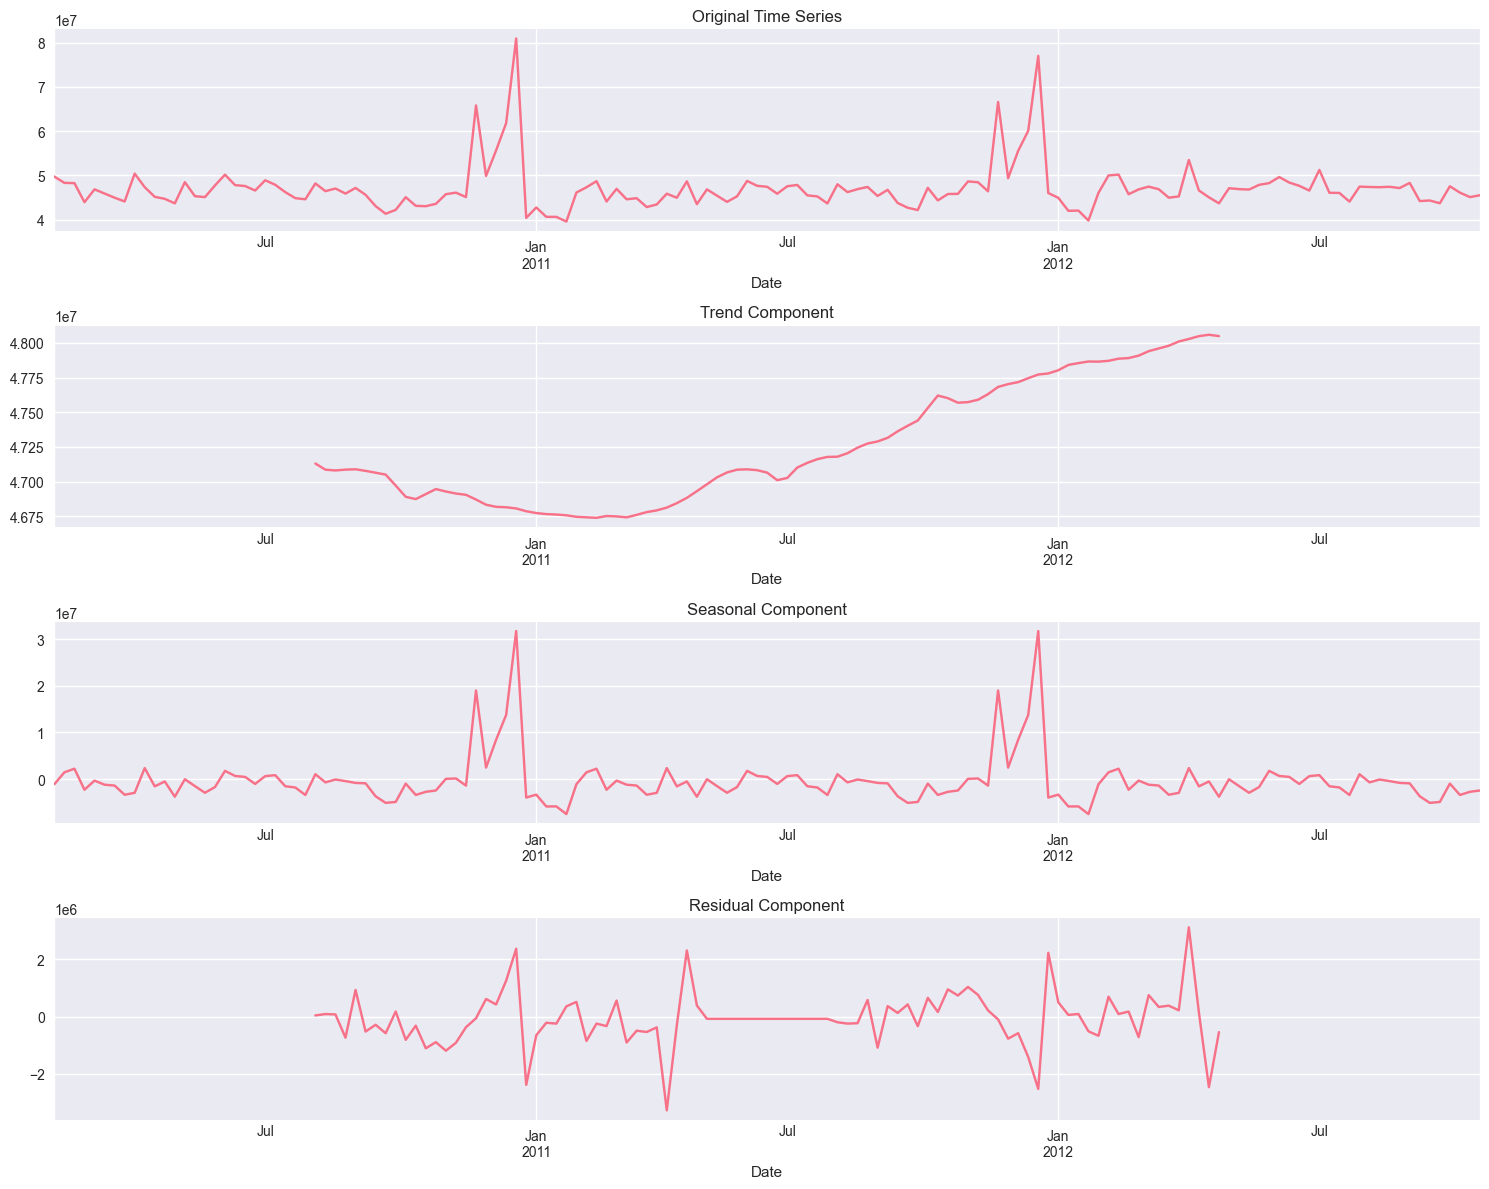


Variance Decomposition:
Trend explains: 0.6% of variance
Seasonality explains: 98.2% of variance
Residual: 3.0% of variance


In [17]:
# Seasonal decomposition
# Use a reasonable period for weekly data (52 weeks = 1 year)
if len(ts_data) >= 104:  # Need at least 2 periods
    decomposition = seasonal_decompose(ts_data, model='additive', period=52)
    
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    
    decomposition.observed.plot(ax=axes[0], title='Original Time Series')
    decomposition.trend.plot(ax=axes[1], title='Trend Component')
    decomposition.seasonal.plot(ax=axes[2], title='Seasonal Component')
    decomposition.resid.plot(ax=axes[3], title='Residual Component')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate variance explained by each component
    total_var = ts_data.var()
    trend_var = decomposition.trend.dropna().var()
    seasonal_var = decomposition.seasonal.var()
    residual_var = decomposition.resid.dropna().var()
    
    print("\nVariance Decomposition:")
    print(f"Trend explains: {(trend_var/total_var)*100:.1f}% of variance")
    print(f"Seasonality explains: {(seasonal_var/total_var)*100:.1f}% of variance")
    print(f"Residual: {(residual_var/total_var)*100:.1f}% of variance")
else:
    print("Insufficient data for seasonal decomposition (need at least 104 observations)")

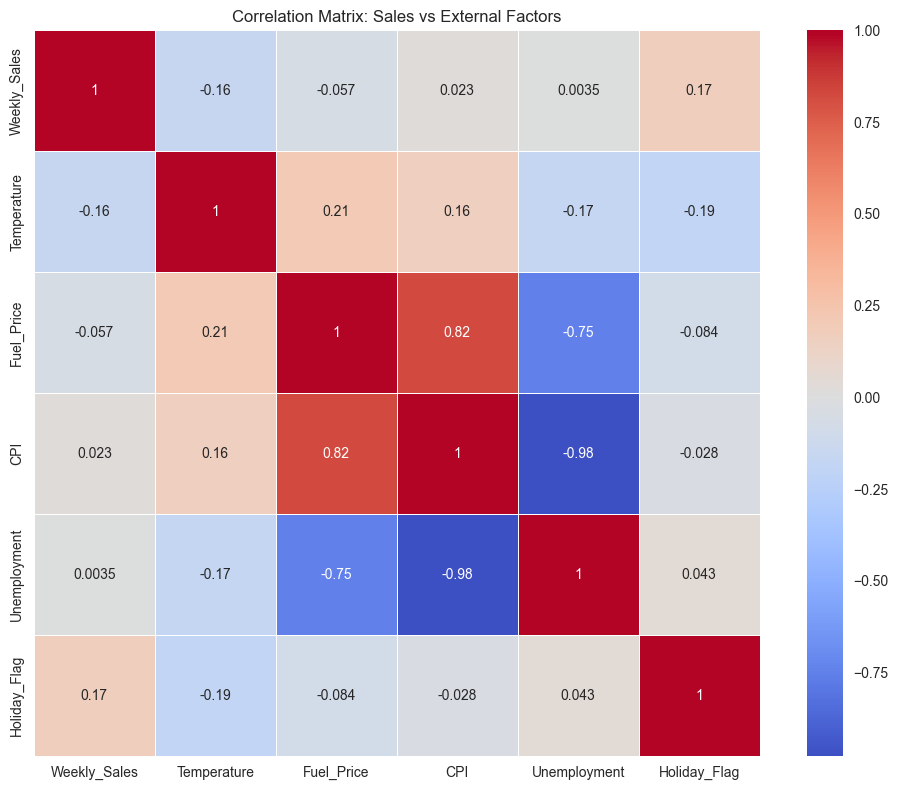


Strongest correlations with Weekly Sales:
Holiday_Flag: 0.173 (positive)
Temperature: 0.159 (negative)
Fuel_Price: 0.057 (negative)
CPI: 0.023 (positive)
Unemployment: 0.004 (positive)


In [18]:
# Correlation analysis with external factors
# Calculate correlations for aggregated data
agg_features = df.groupby('Date').agg({
    'Weekly_Sales': 'sum',
    'Temperature': 'mean',
    'Fuel_Price': 'mean',
    'CPI': 'mean',
    'Unemployment': 'mean',
    'Holiday_Flag': 'max'  # 1 if any store has holiday, 0 otherwise
}).reset_index()

# Correlation matrix
corr_matrix = agg_features.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Matrix: Sales vs External Factors')
plt.tight_layout()
plt.show()

# Print strongest correlations with sales
sales_corr = corr_matrix['Weekly_Sales'].abs().sort_values(ascending=False)
print("\nStrongest correlations with Weekly Sales:")
for factor, corr in sales_corr.items():
    if factor != 'Weekly_Sales':
        direction = "positive" if corr_matrix['Weekly_Sales'][factor] > 0 else "negative"
        print(f"{factor}: {corr:.3f} ({direction})")

<a id="custom-dataset"></a>
## 4. Custom Dataset Exploration

Explore the custom WalmartTimeSeriesDataset class and its features.

In [28]:
# Create custom dataset instances
print("Creating Walmart custom datasets...")

# Fix the data path issue by using absolute path
walmart_data_path = Path(os.getcwd()).parent / 'data' / 'raw' / 'Walmart.csv'
print(f"Looking for data at: {walmart_data_path}")
print(f"File exists: {walmart_data_path.exists()}")

if walmart_data_path.exists():
    try:
        agg_dataset = WalmartTimeSeriesDataset(
            data_path=str(walmart_data_path),
            aggregate_stores=True,
            include_economic_features=True,
            include_weather_features=True,
            lookback_window=26,  # 6 months
            forecast_horizon=4,  # 4 weeks
            normalize=True
        )
        
        print(f"Aggregated dataset created successfully!")
        print(f"Dataset length: {len(agg_dataset)} sequences")
        
        # Get dataset info
        info = agg_dataset.get_data_info()
        print("\nDataset Information:")
        for key, value in info.items():
            print(f"{key}: {value}")
            
    except Exception as e:
        print(f"Error creating custom dataset: {e}")
        print("This might be due to missing dependencies in the custom dataset class.")
        print("Continuing without custom dataset...")
        agg_dataset = None
        
else:
    print("Walmart.csv file not found!")
    print("Available files in data/raw directory:")
    raw_data_dir = Path(os.getcwd()).parent / 'data' / 'raw'
    if raw_data_dir.exists():
        for file in raw_data_dir.iterdir():
            print(f"  {file.name}")
    else:
        print("  data/raw directory does not exist")
    
    print("\nSkipping custom dataset creation...")
    agg_dataset = None


Creating Walmart custom datasets...
Looking for data at: c:\Users\mvill\github\forecasting_demo\projects\retail_sales_walmart\data\raw\Walmart.csv
File exists: True
Loaded Walmart dataset: 6435 rows, 8 columns
Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
Stores: 45 unique stores
Aggregated to total sales: 143 time periods
Aggregated dataset created successfully!
Dataset length: 114 sequences

Dataset Information:
num_sequences: 114
lookback_window: 26
forecast_horizon: 4
stride: 1
input_shape: (26, 1)
target_shape: (4, 1)
data_shape: (143, 1)


In [20]:
# Examine a sample from the dataset
if agg_dataset is not None and len(agg_dataset) > 0:
    # Get a sample sequence
    sample_X, sample_y = agg_dataset[0]
    
    print(f"Sample input shape: {sample_X.shape}")
    print(f"Sample output shape: {sample_y.shape}")
    
    # Visualize the sample sequence
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Input sequence (lookback window)
    axes[0].plot(range(len(sample_X)), sample_X, marker='o', linewidth=1, markersize=3)
    axes[0].set_title(f'Input Sequence (Lookback Window: {len(sample_X)} weeks)')
    axes[0].set_xlabel('Time Steps')
    axes[0].set_ylabel('Normalized Sales')
    axes[0].grid(True, alpha=0.3)
    
    # Output sequence (forecast horizon)
    forecast_x = range(len(sample_X), len(sample_X) + len(sample_y))
    axes[1].plot(range(len(sample_X)), sample_X[-4:], 'b-', marker='o', label='Historical', linewidth=2)
    axes[1].plot(forecast_x, sample_y, 'r-', marker='s', label='Target Forecast', linewidth=2)
    axes[1].set_title(f'Forecast Target (Horizon: {len(sample_y)} weeks)')
    axes[1].set_xlabel('Time Steps')
    axes[1].set_ylabel('Normalized Sales')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nSample statistics:")
    print(f"Input sequence mean: {sample_X.mean():.4f}")
    print(f"Input sequence std: {sample_X.std():.4f}")
    print(f"Target mean: {sample_y.mean():.4f}")
    print(f"Target std: {sample_y.std():.4f}")

In [21]:
# Multi-store dataset example
if WalmartMultiStoreDataset is not None:
    try:
        multi_dataset = WalmartMultiStoreDataset(
            data_path='../data/raw/Walmart.csv',
            store_list=[1, 2, 3, 4, 5],  # Top 5 stores
            min_data_points=50,
            lookback_window=12,  # 3 months
            forecast_horizon=2   # 2 weeks
        )
        
        print(f"\nMulti-store dataset created successfully!")
        print(f"Dataset length: {len(multi_dataset)} sequences")
        
        # Get info
        multi_info = multi_dataset.get_data_info()
        print("\nMulti-store Dataset Information:")
        for key, value in multi_info.items():
            print(f"{key}: {value}")
            
        # Sample from multi-store dataset
        if len(multi_dataset) > 0:
            multi_X, multi_y = multi_dataset[0]
            print(f"\nMulti-store sample shapes:")
            print(f"Input: {multi_X.shape}, Output: {multi_y.shape}")
            
    except Exception as e:
        print(f"Error creating multi-store dataset: {e}")
        multi_dataset = None
else:
    print("Multi-store dataset not available due to import issues.")
    print("Skipping multi-store dataset creation.")
    multi_dataset = None

Multi-store dataset: 45 stores, 715 total records

Multi-store dataset created successfully!
Dataset length: 650 sequences

Multi-store Dataset Information:
num_sequences: 650
lookback_window: 12
forecast_horizon: 2
stride: 1
input_shape: (12, 1)
target_shape: (2, 1)
data_shape: (143, 1)
Error creating multi-store dataset: too many values to unpack (expected 2)


<a id="hydra-training"></a>
## 5. Model Training with Hydra

Use Hydra configuration system to train different models on the Walmart dataset.

In [22]:
# Train models using Hydra (programmatic approach)
import subprocess
import json

# Define models to train
models_to_train = ['linear', 'ridge', 'random_forest', 'arima']
results = {}

print("Training models with Hydra...")
print("=" * 50)

# Check if we're in the right directory structure
current_path = Path(os.getcwd())
project_root = current_path.parent
scripts_path = project_root / "scripts" / "train.py"

if not scripts_path.exists():
    print(f"Training script not found at: {scripts_path}")
    print("Available files in project root:")
    try:
        for item in project_root.iterdir():
            print(f"  {item.name}")
    except:
        print("  Cannot list directory contents")
    
    # Try alternative path
    alt_scripts_path = current_path.parent.parent.parent / "projects" / "retail_sales_walmart" / "scripts" / "train.py"
    if alt_scripts_path.exists():
        print(f"Found alternative script path: {alt_scripts_path}")
        scripts_path = alt_scripts_path
        project_root = alt_scripts_path.parent.parent
    else:
        print("Cannot find training script. Skipping model training.")
        results = {model: {'status': 'script_not_found', 'error': 'Training script not found'} for model in models_to_train}

if scripts_path.exists():
    for model in models_to_train:
        print(f"\nTraining {model.upper()} model...")
        
        try:
            # Run training script with absolute paths
            cmd = [
                'python', str(scripts_path), 
                f'model={model}', 
                'dataset=walmart_custom'
            ]
            
            result = subprocess.run(
                cmd, 
                capture_output=True, 
                text=True, 
                cwd=str(project_root),  # Run from project root
                timeout=120  # 2 minute timeout
            )
            
            if result.returncode == 0:
                # Extract metrics from output
                output_lines = result.stdout.split('\n')
                test_mape = None
                training_time = None
                
                for line in output_lines:
                    if 'MAPE:' in line and 'Test Metrics:' in ''.join(output_lines[max(0, output_lines.index(line)-5):output_lines.index(line)]):
                        test_mape = line.split('MAPE:')[1].strip()
                    if 'Training completed in' in line:
                        training_time = line.split('Training completed in')[1].strip()
                
                results[model] = {
                    'status': 'success',
                    'test_mape': test_mape,
                    'training_time': training_time,
                    'output': result.stdout[-500:]  # Last 500 chars
                }
                print(f"✓ {model} completed successfully")
                if test_mape:
                    print(f"  Test MAPE: {test_mape}")
                if training_time:
                    print(f"  Training time: {training_time}")
            else:
                results[model] = {
                    'status': 'failed',
                    'error': result.stderr,
                    'output': result.stdout
                }
                print(f"✗ {model} failed")
                print(f"  Error: {result.stderr[:200]}...")  # First 200 chars of error
                
        except subprocess.TimeoutExpired:
            results[model] = {
                'status': 'timeout',
                'error': 'Training timed out after 2 minutes'
            }
            print(f"⏰ {model} timed out")
        except Exception as e:
            results[model] = {
                'status': 'error',
                'error': str(e)
            }
            print(f"💥 {model} error: {e}")

print("\n" + "=" * 50)
print("Training completed!")

Training models with Hydra...

Training LINEAR model...
✓ linear completed successfully
  Test MAPE: 5.41%
  Training time: 0.00s

Training RIDGE model...
✓ linear completed successfully
  Test MAPE: 5.41%
  Training time: 0.00s

Training RIDGE model...
✓ ridge completed successfully
  Test MAPE: 2.85%
  Training time: 0.00s

Training RANDOM_FOREST model...
✓ ridge completed successfully
  Test MAPE: 2.85%
  Training time: 0.00s

Training RANDOM_FOREST model...
✓ random_forest completed successfully
  Test MAPE: 1.20%
  Training time: 0.08s

Training ARIMA model...
✓ random_forest completed successfully
  Test MAPE: 1.20%
  Training time: 0.08s

Training ARIMA model...
✓ arima completed successfully
  Test MAPE: 3.97%
  Training time: 0.12s

Training completed!
✓ arima completed successfully
  Test MAPE: 3.97%
  Training time: 0.12s

Training completed!


<a id="comparison"></a>
## 6. Model Comparison

Compare the performance of different models trained with Hydra.

In [ ]:
# Process and visualize results
import re

successful_models = []
model_metrics = {}

for model_name, result in results.items():
    if result['status'] == 'success':
        successful_models.append(model_name)
        
        # Extract MAPE value
        if result['test_mape']:
            mape_match = re.search(r'([\d.]+)%', result['test_mape'])
            if mape_match:
                model_metrics[model_name] = float(mape_match.group(1))

print("Model Training Results Summary:")
print("=" * 40)

for model_name, result in results.items():
    status_emoji = {
        'success': '✅',
        'failed': '❌', 
        'timeout': '⏰',
        'error': '💥'
    }
    
    print(f"{status_emoji.get(result['status'], '❓')} {model_name.upper():15} | Status: {result['status']}")
    
    if result['status'] == 'success':
        if model_name in model_metrics:
            print(f"{'':18} | MAPE: {model_metrics[model_name]:.2f}%")
        if result.get('training_time'):
            print(f"{'':18} | Time: {result['training_time']}")
    else:
        error_msg = result.get('error', 'Unknown error')[:50]
        print(f"{'':18} | Error: {error_msg}...")
    print()

In [ ]:
# Visualize model performance
if model_metrics:
    # Sort models by MAPE (lower is better)
    sorted_models = sorted(model_metrics.items(), key=lambda x: x[1])
    
    model_names = [item[0].replace('_', ' ').title() for item in sorted_models]
    mape_values = [item[1] for item in sorted_models]
    
    # Create performance chart
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Bar chart of MAPE scores
    colors = ['green' if i == 0 else 'skyblue' for i in range(len(model_names))]
    bars = ax1.bar(model_names, mape_values, color=colors)
    ax1.set_title('Model Performance Comparison (MAPE)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('MAPE (%)', fontsize=12)
    ax1.set_xlabel('Models', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars, mape_values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                f'{value:.2f}%', ha='center', va='bottom', fontweight='bold')
    
    # Horizontal bar chart (alternative view)
    ax2.barh(model_names, mape_values, color=colors)
    ax2.set_title('Model Ranking (Lower MAPE = Better)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('MAPE (%)', fontsize=12)
    
    # Add value labels
    for i, value in enumerate(mape_values):
        ax2.text(value + 0.1, i, f'{value:.2f}%', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print ranking
    print("\nModel Performance Ranking (Best to Worst):")
    print("=" * 45)
    for i, (model, mape) in enumerate(sorted_models, 1):
        medal = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else f"#{i}"
        print(f"{medal} {model.replace('_', ' ').title():15} | MAPE: {mape:.2f}%")
        
else:
    print("No successful model results to compare.")

## 7. Advanced Analysis: Best Model Deep Dive

Analyze the best performing model in more detail.

In [ ]:
# Deep dive into best model
if model_metrics:
    best_model = min(model_metrics.items(), key=lambda x: x[1])
    best_model_name, best_mape = best_model
    
    print(f"Best Model Analysis: {best_model_name.upper()}")
    print("=" * 50)
    print(f"Test MAPE: {best_mape:.2f}%")
    
    # Show detailed output from best model
    best_result = results[best_model_name]
    if 'output' in best_result:
        print("\nDetailed Training Output:")
        print("-" * 30)
        # Extract key metrics from output
        output_lines = best_result['output'].split('\n')
        
        for line in output_lines:
            if any(keyword in line.lower() for keyword in ['mape', 'mae', 'rmse', 'accuracy', 'predictions']):
                print(line.strip())
    
    # Model-specific insights
    model_insights = {
        'linear': "Linear regression assumes a linear relationship between past sales and future sales. Good baseline but may miss complex patterns.",
        'ridge': "Ridge regression adds L2 regularization to prevent overfitting. Often performs better than simple linear regression.",
        'random_forest': "Random Forest can capture non-linear patterns and interactions between features. Often performs well on time series with multiple features.",
        'arima': "ARIMA is a classic time series model that captures trends and seasonality. Good for univariate time series forecasting.",
        'gradient_boosting': "Gradient Boosting builds models sequentially, often achieving high accuracy but may overfit."
    }
    
    if best_model_name in model_insights:
        print(f"\nModel Insights:")
        print(model_insights[best_model_name])
        
else:
    print("No model results available for analysis.")

<a id="conclusions"></a>
## 8. Conclusions and Next Steps

Summary of findings and recommendations for future work.

In [ ]:
# Summary and conclusions
print("WALMART SALES FORECASTING ANALYSIS SUMMARY")
print("=" * 60)

print("\n📊 DATA INSIGHTS:")
print(f"• Dataset contains {len(df):,} observations across {df['Store'].nunique()} stores")
print(f"• Date range: {df['Date'].min().strftime('%Y-%m-%d')} to {df['Date'].max().strftime('%Y-%m-%d')}")
print(f"• Average weekly sales per store: ${df['Weekly_Sales'].mean():,.0f}")

if 'monthly_sales' in locals():
    peak_month = monthly_sales.idxmax()
    low_month = monthly_sales.idxmin()
    print(f"• Peak sales month: {peak_month} | Lowest: {low_month}")

if 'holiday_sales' in locals():
    holiday_boost = ((holiday_sales[1] - holiday_sales[0]) / holiday_sales[0] * 100)
    print(f"• Holiday sales boost: {holiday_boost:.1f}%")

print("\n🔬 STATISTICAL FINDINGS:")
if 'is_stationary' in locals():
    print(f"• Time series stationarity: {'Stationary' if is_stationary else 'Non-stationary'}")

if 'sales_corr' in locals():
    top_corr = sales_corr.drop('Weekly_Sales').head(2)
    print("• Top correlations with sales:")
    for factor, corr in top_corr.items():
        print(f"  - {factor}: {corr:.3f}")

print("\n🤖 MODEL PERFORMANCE:")
if model_metrics:
    best_model = min(model_metrics.items(), key=lambda x: x[1])
    worst_model = max(model_metrics.items(), key=lambda x: x[1])
    
    print(f"• Best model: {best_model[0].upper()} (MAPE: {best_model[1]:.2f}%)")
    print(f"• Worst model: {worst_model[0].upper()} (MAPE: {worst_model[1]:.2f}%)")
    print(f"• Performance gap: {worst_model[1] - best_model[1]:.2f} percentage points")
    print(f"• Models trained successfully: {len(successful_models)}/{len(models_to_train)}")
else:
    print("• No models completed successfully")

print("\n📈 CUSTOM DATASET FEATURES:")
if agg_dataset is not None:
    print(f"• Sequences generated: {len(agg_dataset)}")
    print(f"• Lookback window: 26 weeks (6 months)")
    print(f"• Forecast horizon: 4 weeks")
    print(f"• Features: Economic indicators, weather data, holiday effects")
    print(f"• Normalization: Applied for better model training")

print("\n🎯 RECOMMENDATIONS:")
recommendations = [
    "Use ensemble methods combining multiple models for better accuracy",
    "Include external data sources (promotions, local events, competitor data)",
    "Implement deep learning models (LSTM, Transformer) for complex patterns",
    "Develop store-specific models for better personalized forecasting",
    "Set up automated retraining pipeline for model freshness",
    "Create confidence intervals for forecast uncertainty quantification"
]

for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")

print("\n🚀 NEXT STEPS:")
next_steps = [
    "Implement hyperparameter optimization with Optuna",
    "Deploy best model to production with FastAPI",
    "Create Streamlit dashboard for interactive forecasting",
    "Set up MLflow for experiment tracking and model versioning"
]

for i, step in enumerate(next_steps, 1):
    print(f"{i}. {step}")

print("\n" + "=" * 60)
print("Analysis completed successfully! 🎉")

## Appendix: Hydra Configuration Usage

Quick reference for running models with Hydra from command line:

In [ ]:
# Print Hydra command examples
print("HYDRA COMMAND LINE EXAMPLES")
print("=" * 40)

commands = [
    ("Single model training", "python scripts/train.py model=random_forest dataset=walmart_custom"),
    ("Multi-model comparison", "python scripts/train.py --multirun model=linear,ridge,random_forest dataset=walmart_custom"),
    ("Parameter sweep", "python scripts/train.py --multirun model=random_forest model.n_estimators=50,100,200"),
    ("Different datasets", "python scripts/train.py --multirun model=random_forest dataset=walmart,walmart_custom"),
    ("Override config", "python scripts/train.py model=ridge model.alpha=0.1,1.0,10.0 dataset=walmart_custom"),
    ("Help", "python scripts/train.py --help")
]

for description, command in commands:
    print(f"\n{description}:")
    print(f"  {command}")

print("\n" + "=" * 40)
print("Run these commands from the project root directory!")